In [ ]:
import numpy as np
import pandas as pd
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier,Pool
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import optuna

In [ ]:
load_dotenv(r'.env')
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
df = pd.read_sql('select * from ecommerce_features',engine )
df = df.set_index('CustomerID')

Я выбрал catboost, потому что она лучше всех, рассмотренных моделей, по показателям precision,recall,f1,roc-auc, и время инференса

In [13]:
X = df.drop(['Churn'],axis=1)
y = df['Churn']
X_train_full,X_test,y_train_full,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.2,random_state=42)


In [14]:
#CatBoost
cat_columns = X_train.select_dtypes(exclude='number').columns.to_list()
eval_pool = Pool(X_val,y_val,cat_features=cat_columns)
train_pool = Pool(X_train,y_train,cat_features=cat_columns)
model_cb = CatBoostClassifier(iterations=5000,eval_metric='Logloss')

#RandomForest

model_rf = RandomForestClassifier(n_estimators=5000,criterion='log_loss')
num_columns = X_train.select_dtypes(include='number').columns
cat_columns = X_train.select_dtypes(exclude='number').columns
ct_rf = ColumnTransformer(
    [
        ('num',StandardScaler(),num_columns),
        ('cat',OneHotEncoder(),cat_columns)
    ]
    
)
pl_rf = Pipeline([
    ('preprocess',ct_rf),
    ('classifier',model_rf)
])
#MLP
model_mlp = MLPClassifier()

num_columns = X_train.select_dtypes(include='number').columns
cat_columns = X_train.select_dtypes(exclude='number').columns
ct_mlp = ColumnTransformer(
    [
        ('num',StandardScaler(),num_columns),
        ('cat',OneHotEncoder(),cat_columns)
    ]
    
)

pl_mlp = Pipeline([
    ('preprocess',ct_mlp),
    ('classifier',model_mlp)
])

#LogReg
model_logreg = LogisticRegression()

num_columns = X_train.select_dtypes(include='number').columns
cat_columns = X_train.select_dtypes(exclude='number').columns
ct_logreg = ColumnTransformer(
    [
        ('num',StandardScaler(),num_columns),
        ('cat',OneHotEncoder(),cat_columns)
    ]
    
)

pl_logreg = Pipeline([
    ('preprocess',ct_logreg),
    ('classifier',model_logreg)
])




In [15]:
model_cb.fit(train_pool,eval_set=eval_pool,early_stopping_rounds=30,use_best_model=True,verbose=False)
pl_rf.fit(X_train,y_train)
pl_mlp.fit(X_train,y_train)
pl_logreg.fit(X_train,y_train)

c:\Users\t.gumerov\final_certification\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers

In [ ]:
#Metrics catboost
start_cb = time.perf_counter()
pred_cb = model_cb.predict(X_test)
end_cb = time.perf_counter()
pred_proba_cb=model_cb.predict_proba(X_test)
precision_cb = np.round(precision_score(y_test,pred_cb),4)
recall_cb = np.round(recall_score(y_test,pred_cb),4)
f1_cb = np.round(f1_score(y_test,pred_cb),4)
roc_auc_cb = np.round(roc_auc_score(y_test,pred_proba_cb[:,1]),4)
time_inference_ms_cb = round((end_cb-start_cb)/X_test.shape[0] * 1000,4)

#Metrics RandomForest
start_rf = time.perf_counter()
pred_rf = pl_rf.predict(X_test)
end_rf = time.perf_counter()
pred_proba_rf=pl_rf.predict_proba(X_test)
precision_rf = np.round(precision_score(y_test,pred_rf),4)
recall_rf = np.round(recall_score(y_test,pred_rf),4)
f1_rf = np.round(f1_score(y_test,pred_rf),4)
roc_auc_rf = np.round(roc_auc_score(y_test,pred_proba_rf[:,1]),4)
time_inference_ms_rf = round((end_rf-start_rf)/X_test.shape[0] * 1000,4)

#Metrics MLP
start_mpl = time.perf_counter()
pred_mlp = pl_mlp.predict(X_test)
end_mlp = time.perf_counter()
pred_proba_mlp=pl_mlp.predict_proba(X_test)
precision_mlp = np.round(precision_score(y_test,pred_mlp),4)
recall_mlp = np.round(recall_score(y_test,pred_mlp),4)
f1_mlp = np.round(f1_score(y_test,pred_mlp),4)
roc_auc_mlp = np.round(roc_auc_score(y_test,pred_proba_mlp[:,1]),4)
time_inference_ms_mlp = np.round((end_mlp-start_mpl)/X_test.shape[0] * 1000,4)

#Metrics Logreg
start_logreg = time.perf_counter()
pred_logreg = pl_logreg.predict(X_test)
end_logreg = time.perf_counter()
pred_proba_logreg=pl_logreg.predict_proba(X_test)
precision_logreg = np.round(precision_score(y_test,pred_logreg),4)
recall_logreg = np.round(recall_score(y_test,pred_logreg),4)
f1_logreg = np.round(f1_score(y_test,pred_logreg),4)
roc_auc_logreg = np.round(roc_auc_score(y_test,pred_proba_logreg[:,1]),4)
time_inference_ms_logreg = np.round((end_logreg-start_logreg)/X_test.shape[0] * 1000,4)



In [17]:
#Summarize results

results = pd.DataFrame({
    'Model':['Catboost','RandomForest','MLP','LogReg'],
    'Precision':[precision_cb,precision_rf,precision_mlp,precision_logreg],
    'Recall':[recall_cb,recall_rf,recall_mlp,recall_logreg],
    'F1':[f1_cb,f1_rf,f1_mlp,f1_logreg],
    'ROC_AUC':[roc_auc_cb,roc_auc_rf,roc_auc_mlp,roc_auc_logreg],
    'time_inferense(ms)':[time_inference_ms_cb,time_inference_ms_rf,time_inference_ms_mlp,time_inference_ms_logreg]
})
results

,Model,Precision,Recall,F1,ROC_AUC,time_inferense(ms)
0,Catboost,0.9420,0.8904,0.9155,0.9933,0.0107
1,RandomForest,0.9667,0.7945,0.8722,0.9923,1.2502
2,MLP,0.8030,0.7260,0.7626,0.9747,0.0096
3,LogReg,0.7037,0.5205,0.5984,0.8851,0.0105


По всем показателям победил Catboost. Стоит выбрать его для использования.

Такие результаты получены с параметрами по умолчанию

Проведу подбор гиперпараметров

In [18]:
def objective_catboost(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "early_stopping_rounds": 50,
        "verbose": False,
        "random_seed": 42,
        "eval_metric": "Logloss"
    }

    cat_columns = X_train.select_dtypes(exclude='number').columns.to_list()
    train_pool = Pool(X_train, y_train, cat_features=cat_columns)
    eval_pool = Pool(X_val, y_val, cat_features=cat_columns)

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=eval_pool, use_best_model=True)

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

def objective_rf(trial):

    n_estimators = trial.suggest_int("n_estimators", 100, 2000)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    num_columns = X_train.select_dtypes(include='number').columns
    cat_columns = X_train.select_dtypes(exclude='number').columns

    ct = ColumnTransformer([
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ])

    pipeline = Pipeline([
        ('preprocess', ct),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return f1_score(y_val, y_pred)

def objective_mlp(trial):

    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"n_units_l{i}", 16, 256))

    alpha = trial.suggest_float("alpha", 1e-6, 1e-1, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-1, log=True)

    model = MLPClassifier(
        hidden_layer_sizes=tuple(layers),
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )

    num_columns = X_train.select_dtypes(include='number').columns
    cat_columns = X_train.select_dtypes(exclude='number').columns

    ct = ColumnTransformer([
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ])

    pipeline = Pipeline([
        ('preprocess', ct),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return f1_score(y_val, y_pred)

def objective_logreg(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.1, 0.9)
        solver = "saga"
    else:
        l1_ratio = None
        solver = "liblinear" if penalty == "l1" else "lbfgs"

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        l1_ratio=l1_ratio,
        solver=solver,
        max_iter=1000,
        random_state=42
    )

    num_columns = X_train.select_dtypes(include='number').columns
    cat_columns = X_train.select_dtypes(exclude='number').columns

    ct = ColumnTransformer([
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ])

    pipeline = Pipeline([
        ('preprocess', ct),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return f1_score(y_val, y_pred)


In [19]:
study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=30)

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30)

study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=30)

study_logreg = optuna.create_study(direction="maximize")
study_logreg.optimize(objective_logreg, n_trials=30)

[I 2025-12-16 16:07:35,735] A new study created in memory with name: no-name-7eb45ad6-e815-41f4-ac53-5a788e631f24
[I 2025-12-16 16:07:45,500] Trial 0 finished with value: 0.8991596638655462 and parameters: {'iterations': 1095, 'learning_rate': 0.20603471383931798, 'depth': 9}. Best is trial 0 with value: 0.8991596638655462.
[I 2025-12-16 16:07:52,706] Trial 1 finished with value: 0.751131221719457 and parameters: {'iterations': 456, 'learning_rate': 0.06752619918558418, 'depth': 4}. Best is trial 0 with value: 0.8991596638655462.
[I 2025-12-16 16:08:23,802] Trial 2 finished with value: 0.8983050847457628 and parameters: {'iterations': 1325, 'learning_rate': 0.05198404013557428, 'depth': 8}. Best is trial 0 with value: 0.8991596638655462.
[I 2025-12-16 16:09:21,302] Trial 3 finished with value: 0.8776371308016878 and parameters: {'iterations': 2243, 'learning_rate': 0.022026261133812636, 'depth': 10}. Best is trial 0 with value: 0.8991596638655462.
[I 2025-12-16 16:09:44,104] Trial 4 fi

In [20]:
results_opt = pd.DataFrame({
    "Model":['CatBoost','RandomForest','MLP','LogReg'],
    'F1':[study_cb.best_value,study_rf.best_value,study_mlp.best_value,study_logreg.best_value]
})
results_opt

,Model,F1
0,CatBoost,0.919831
1,RandomForest,0.869919
2,MLP,0.867769
3,LogReg,0.597015


После подбора гиперпараметров победил catboost по метрике f1. Буду использовать его его


In [21]:
best_params_cb = study_cb.best_params
best_params_cb


{'iterations': 1875, 'learning_rate': 0.10851878131004626, 'depth': 8}

In [22]:
cat_columns = X_train_full.select_dtypes(exclude='number').columns.to_list()
#eval_pool = Pool(X_val,y_val,cat_features=cat_columns)
train_pool = Pool(X_train_full,y_train_full,cat_features=cat_columns)
model_cb = CatBoostClassifier(**best_params_cb)

In [23]:
model_cb.fit(train_pool)

0:	learn: 0.5627634	total: 26.6ms	remaining: 49.9s
1:	learn: 0.4836832	total: 50.3ms	remaining: 47.1s
2:	learn: 0.4172228	total: 80.6ms	remaining: 50.3s
3:	learn: 0.3702825	total: 111ms	remaining: 51.7s
4:	learn: 0.3266664	total: 141ms	remaining: 52.6s
5:	learn: 0.2970193	total: 171ms	remaining: 53.3s
6:	learn: 0.2755856	total: 201ms	remaining: 53.5s
7:	learn: 0.2540558	total: 231ms	remaining: 53.9s
8:	learn: 0.2356725	total: 261ms	remaining: 54.1s
9:	learn: 0.2213768	total: 290ms	remaining: 54.2s
10:	learn: 0.2202210	total: 297ms	remaining: 50.4s
11:	learn: 0.2127641	total: 327ms	remaining: 50.7s
12:	learn: 0.2065083	total: 357ms	remaining: 51.1s
13:	learn: 0.1966973	total: 387ms	remaining: 51.4s
14:	learn: 0.1920180	total: 417ms	remaining: 51.7s
15:	learn: 0.1860683	total: 446ms	remaining: 51.8s
16:	learn: 0.1800141	total: 476ms	remaining: 52s
17:	learn: 0.1757056	total: 508ms	remaining: 52.4s
18:	learn: 0.1713530	total: 539ms	remaining: 52.6s
19:	learn: 0.1668231	total: 568ms	remain

In [24]:
model_cb.save_model('catboost_best.cbm')

In [ ]:
start_cb = time.perf_counter()
pred_cb = model_cb.predict(X_test)
end_cb = time.perf_counter()
pred_proba_cb=model_cb.predict_proba(X_test)
precision_cb = np.round(precision_score(y_test,pred_cb),4)
recall_cb = np.round(recall_score(y_test,pred_cb),4)
f1_cb = np.round(f1_score(y_test,pred_cb),4)
roc_auc_cb = np.round(roc_auc_score(y_test,pred_proba_cb[:,1]),4)
time_inference_ms_cb = round((end_cb-start_cb)/X_test.shape[0] * 1000,4)

In [ ]:
results = pd.DataFrame({
    'Model':['Catboost'],
    'Precision':[precision_cb],
    'Recall':[recall_cb],
    'F1':[f1_cb],
    'ROC_AUC':[roc_auc_cb],
    'time_inferense(ms)':[time_inference_ms_cb]
})
results

,Model,Precision,Recall,F1,ROC_AUC,time_inferense(ms)
0,Catboost,0.9714,0.9315,0.951,0.9971,0.0114


Важность признаков. 

In [25]:
feature_importance = pd.DataFrame({'feature':model_cb.feature_names_,'importance':model_cb.feature_importances_}).sort_values('importance',ascending=False)


<Axes: xlabel='importance', ylabel='feature'>

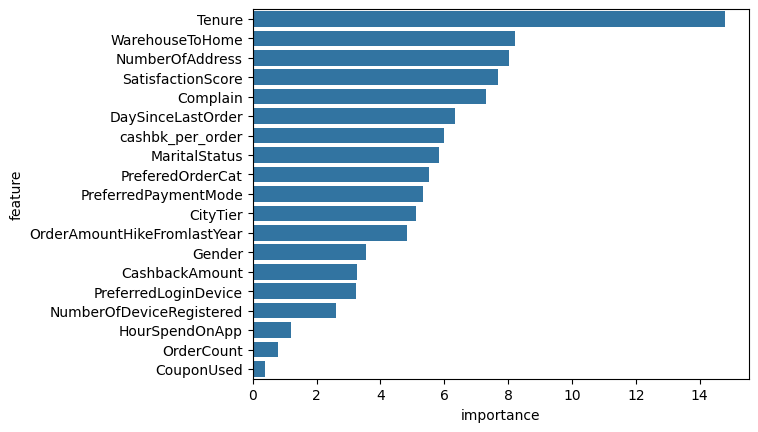

In [28]:
sns.barplot(feature_importance,x='importance',y='feature')

Видно, что самый важный признак это Tenure - сколько клиент находится в организации. Это логично, старые клиенты более лояльны и они не уходят, а новые клиенты могут прийти за конкретным товаром или купить по акции товар и уйти.

WarehouseToHome - то же важно, вероятно из - за того, что удаленность от склада влияет на время доставки товаров.